In [1]:
import os
import glob
import numpy as np
import pandas as pd
import mne
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

In [2]:

# Define paths (Adjust base_path if your script is not in the root folder)
BASE_PATH = "Data_sub01"

# ==========================================
# PART 1: DATA LOADING FUNCTIONS
# ==========================================

def load_eeg_data(subject_id, session="ses-eeg", task="words"):
    eeg_dir = os.path.join(BASE_PATH, "Async_data_preproc_new", subject_id, session, "eeg")
    search_pattern = os.path.join(eeg_dir, f"*{subject_id}*desc-{task}_epo.fif")
    
    found_files = glob.glob(search_pattern)
    if not found_files:
        raise FileNotFoundError(f"No EEG file found matching: {search_pattern}")
    
    main_file = found_files[0]
    print(f"Loading EEG file: {main_file}")
    epochs = mne.read_epochs(main_file, preload=True, verbose=False)
    
    X = epochs.get_data(copy=True) 
    y = epochs.events[:, -1]
    
    print(f"EEG Data Loaded. Shape: {X.shape}")
    return epochs, X, y

def load_fmri_beta_maps(subject_id, session_id):
    base_fmri_dir = os.path.join(BASE_PATH, "beta_images_activation_async")
    image_dir = os.path.join(base_fmri_dir, f"single_trial_{session_id}")
    
    # Handle filename differences between session 1 and 2
    session_suffix = "session1" if session_id == "sess1" else "session2"
    csv_filename = f"beta_labels_{subject_id}_{session_suffix}.csv"
    csv_path = os.path.join(base_fmri_dir, csv_filename)
    
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Labels CSV not found at: {csv_path}")
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Beta map directory not found at: {image_dir}")
        
    print(f"Loading fMRI labels from: {csv_path}")
    labels_df = pd.read_csv(csv_path)
    
    nii_files = sorted(glob.glob(os.path.join(image_dir, "*.nii*")))
    
    if len(nii_files) != len(labels_df):
        print(f"Warning: {len(nii_files)} images vs {len(labels_df)} labels. Trimming...")
        min_len = min(len(nii_files), len(labels_df))
        nii_files = nii_files[:min_len]
        labels_df = labels_df.iloc[:min_len]
    
    print(f"Loading {len(nii_files)} Beta maps...")
    images = [nib.load(f).get_fdata(dtype=np.float32) for f in nii_files]
    fmri_data = np.stack(images, axis=0)
    
    print(f"fMRI Data Loaded. Shape: {fmri_data.shape}")
    return fmri_data, labels_df

In [4]:
print("\n--- 1. LOADING DATA ---")
try:
    # Load EEG
    eeg_epochs, eeg_data, eeg_labels = load_eeg_data(subject_id="sub-01")
    
    # Load fMRI (Session 1)
    fmri_data_ses01, fmri_labels_df_ses01 = load_fmri_beta_maps(subject_id="subject1", session_id="sess1")
    fmri_data_ses02, fmri_labels_df_ses02 = load_fmri_beta_maps(subject_id="subject1", session_id="sess2")
    fmri_data = np.concatenate([fmri_data_ses01, fmri_data_ses02], axis=0)
    fmri_labels_df = pd.concat([fmri_labels_df_ses01, fmri_labels_df_ses02], ignore_index=True)
    fmri_labels = fmri_labels_df['label'].values if 'label' in fmri_labels_df else fmri_labels_df.iloc[:, 1].values
    
except Exception as e:
    print(f"CRITICAL ERROR LOADING DATA: {e}")
    exit()


--- 1. LOADING DATA ---
Loading EEG file: Data_sub01\Async_data_preproc_new\sub-01\ses-eeg\eeg\sub-01_ses-eeg_task-innerspeech_desc-words_epo.fif
EEG Data Loaded. Shape: (320, 64, 1537)
Loading fMRI labels from: Data_sub01\beta_images_activation_async\beta_labels_subject1_session1.csv
Loading 160 Beta maps...
fMRI Data Loaded. Shape: (160, 79, 95, 79)
Loading fMRI labels from: Data_sub01\beta_images_activation_async\beta_labels_subject1_session2.csv
Loading 160 Beta maps...
fMRI Data Loaded. Shape: (160, 79, 95, 79)


In [5]:
def clean_fmri_data(X):
    """Replaces NaNs with 0.0 to fix background mismatches."""
    if np.isnan(X).any():
        print(f"Cleaning data: Replacing NaNs with 0.0...")
        return np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    return X

def augment_eeg_window_slicing(X, y, window_size, stride):
    """Slices EEG epochs into smaller overlapping windows."""
    n_epochs, n_channels, n_times = X.shape
    X_aug, y_aug = [], []
    start_indices = range(0, n_times - window_size + 1, stride)
    
    for i in range(n_epochs):
        for start in start_indices:
            end = start + window_size
            crop = X[i, :, start:end]
            X_aug.append(crop)
            y_aug.append(y[i])
            
    return np.array(X_aug), np.array(y_aug)

def augment_fmri_rotation(X, y, max_angle=5):
    """Rotates brains and concatenates results (Doubles dataset size)."""
    X_rotated, y_rotated = [], []
    print(f"Augmenting {len(X)} samples with Rotation...")
    
    for i in range(len(X)):
        img = X[i]
        angle = np.random.uniform(-max_angle, max_angle)
        # cval=0.0 ensures background remains 0
        img_rot = rotate(img, angle, axes=(0, 1), reshape=False, order=1, cval=0.0)
        X_rotated.append(img_rot)
        y_rotated.append(y[i])
        
    return np.concatenate([X, np.array(X_rotated)]), np.concatenate([y, np.array(y_rotated)])

def augment_fmri_intensity(X, noise_level=0.02, ignore_background=True):
    """Adds random Gaussian noise but preserves the zero-background."""
    print(f"Augmenting {len(X)} samples with Intensity Noise...")
    noise = np.random.normal(0, noise_level, X.shape)
    
    # Create the augmented data
    X_aug = X + noise
    
    # CRITICAL: Force the background back to 0.0
    # Anywhere the original image was 0, make the new image 0 too
    if ignore_background:
        X_aug[X == 0] = 0.0
    
    return X_aug

In [6]:
# --- 2. AUGMENT EEG ---
print("\n--- 2. AUGMENTING EEG ---")
# Get actual sampling rate from data
sfreq = int(eeg_epochs.info['sfreq'])
print(f"Detected Sampling Rate: {sfreq} Hz")

# Config: 2.0s window, 0.5s stride
win_len = int(2.5 * sfreq)
stride_len = int(0.5 * sfreq)

# Check if window is valid
if win_len > eeg_data.shape[2]:
    print("Warning: Window size is larger than original epoch! Reducing to 1.0s...")
    win_len = int(1.0 * sfreq)

X_eeg_aug, y_eeg_aug = augment_eeg_window_slicing(eeg_data, eeg_labels, win_len, stride_len)

print(f"Original EEG: {eeg_data.shape}")
print(f"Augmented EEG: {X_eeg_aug.shape}")
print(f"Gain: {len(X_eeg_aug) / len(eeg_data):.1f}x")

# --- 3. AUGMENT fMRI ---
print("\n--- 3. AUGMENTING fMRI ---")
fmri_clean = clean_fmri_data(fmri_data)

# B. Generate Rotation (Geometric)
# X_fmri_geo will be 2x size of fmri_clean
X_fmri_geo, y_fmri_geo = augment_fmri_rotation(fmri_clean, fmri_labels, max_angle=5)

# C. Generate Noise (Intensity)
# Applied to X_fmri_geo, so X_fmri_aug is same size as geo
X_fmri_aug = augment_fmri_intensity(X_fmri_geo, noise_level=0.05)


print(f"Original fMRI: {fmri_data.shape}")
print(f"Augmented fMRI (Rotation): {X_fmri_geo.shape}")
print(f"Gain: {len(X_fmri_geo) / len(fmri_data):.1f}x")
print(f"Augmented fMRI (Intensity Noise): {X_fmri_aug.shape}")
print(f"Gain: {len(X_fmri_aug) / len(fmri_data):.1f}x")



--- 2. AUGMENTING EEG ---
Detected Sampling Rate: 512 Hz
Original EEG: (320, 64, 1537)
Augmented EEG: (640, 64, 1280)
Gain: 2.0x

--- 3. AUGMENTING fMRI ---
Cleaning data: Replacing NaNs with 0.0...
Augmenting 320 samples with Rotation...
Augmenting 640 samples with Intensity Noise...
Original fMRI: (320, 79, 95, 79)
Augmented fMRI (Rotation): (640, 79, 95, 79)
Gain: 2.0x
Augmented fMRI (Intensity Noise): (640, 79, 95, 79)
Gain: 2.0x


In [7]:
def plot_eeg_augmentation(X_orig, X_aug, orig_idx=0, channel_idx=10, fs=1024):
    """Plots original EEG vs crops."""
    orig_data = X_orig[orig_idx, channel_idx, :]
    time_orig = np.arange(len(orig_data)) / fs
    
    # Estimate which crops belong to this trial
    n_crops = len(X_aug) // len(X_orig)
    start_idx = orig_idx * n_crops
    related_crops = X_aug[start_idx : start_idx + n_crops]
    
    fig, axes = plt.subplots(len(related_crops) + 1, 1, figsize=(10, 8), sharex=False)
    
    # Plot Original
    axes[0].plot(time_orig, orig_data, 'k', label='Original')
    axes[0].set_title(f"Original Trial {orig_idx} (Channel {channel_idx})")
    
    # Plot Crops
    for i, crop in enumerate(related_crops):
        time_shift = i * 0.5 # Assuming 0.5s stride
        crop_data = crop[channel_idx, :]
        time_crop = np.arange(len(crop_data)) / fs + time_shift
        
        ax = axes[i+1]
        ax.plot(time_crop, crop_data, 'tab:blue', linestyle='--')
        ax.set_title(f"Crop {i+1}")
        ax.set_ylim(axes[0].get_ylim())
        
    plt.tight_layout()
    plt.show()

def plot_fmri_augmentation(X_ref, X_aug, trial_idx=0, title_suffix=""):
    """
    Plots Original vs Augmented.
    Handles both Concatenated (Rotation) and Direct (Noise) augmentations.
    """
    z_slice = X_ref.shape[3] // 2 
    img_ref = X_ref[trial_idx, :, :, z_slice]
    
    # --- LOGIC TO FIND THE MATCHING AUGMENTED IMAGE ---
    # Case 1: Concatenated (Rotation) -> Augmented image is at index N + i
    if len(X_aug) == 2 * len(X_ref):
        aug_idx = len(X_ref) + trial_idx
        aug_type = "Concatenated (Rotation)"
    # Case 2: Direct (Noise) -> Augmented image is at index i
    elif len(X_aug) == len(X_ref):
        aug_idx = trial_idx
        aug_type = "Direct (Noise)"
    else:
        # Fallback
        aug_idx = trial_idx
        aug_type = "Unknown"

    img_aug = X_aug[aug_idx, :, :, z_slice]
    
    # --- MASKING BACKGROUND (Makes 0s white) ---
    img_ref_m = np.ma.masked_where(img_ref == 0, img_ref)
    img_aug_m = np.ma.masked_where(img_aug == 0, img_aug)
    diff = img_aug - img_ref
    diff_m = np.ma.masked_where(diff == 0, diff)
    
    # --- PLOTTING ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    im1 = axes[0].imshow(img_ref_m.T, cmap='magma', origin='lower')
    axes[0].set_title(f"Reference Image")
    plt.colorbar(im1, ax=axes[0])
    
    # Augmented
    im2 = axes[1].imshow(img_aug_m.T, cmap='magma', origin='lower')
    axes[1].set_title(f"Augmented ({aug_type})")
    plt.colorbar(im2, ax=axes[1])
    
    # Difference
    limit = np.max(np.abs(diff)) if np.max(np.abs(diff)) > 0 else 1
    im3 = axes[2].imshow(diff_m.T, cmap='seismic', origin='lower', vmin=-limit, vmax=limit)
    axes[2].set_title(f"Difference Map {title_suffix}")
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()


--- Plotting EEG Augmentation ---


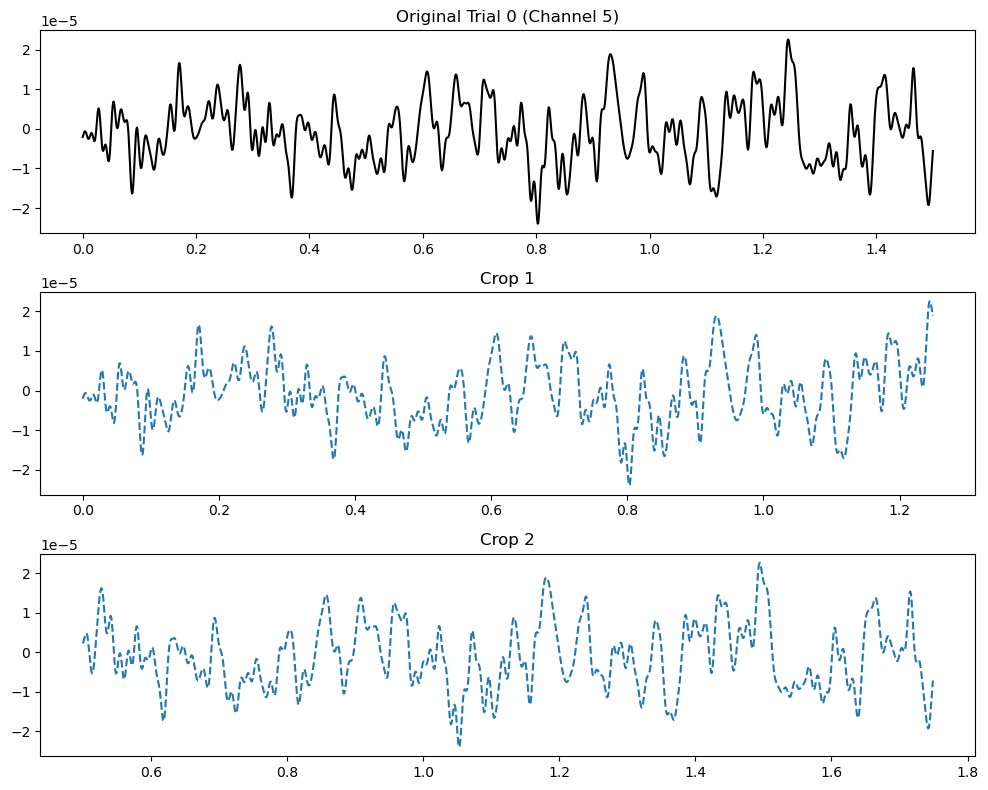


--- Plotting fMRI Rotation ---


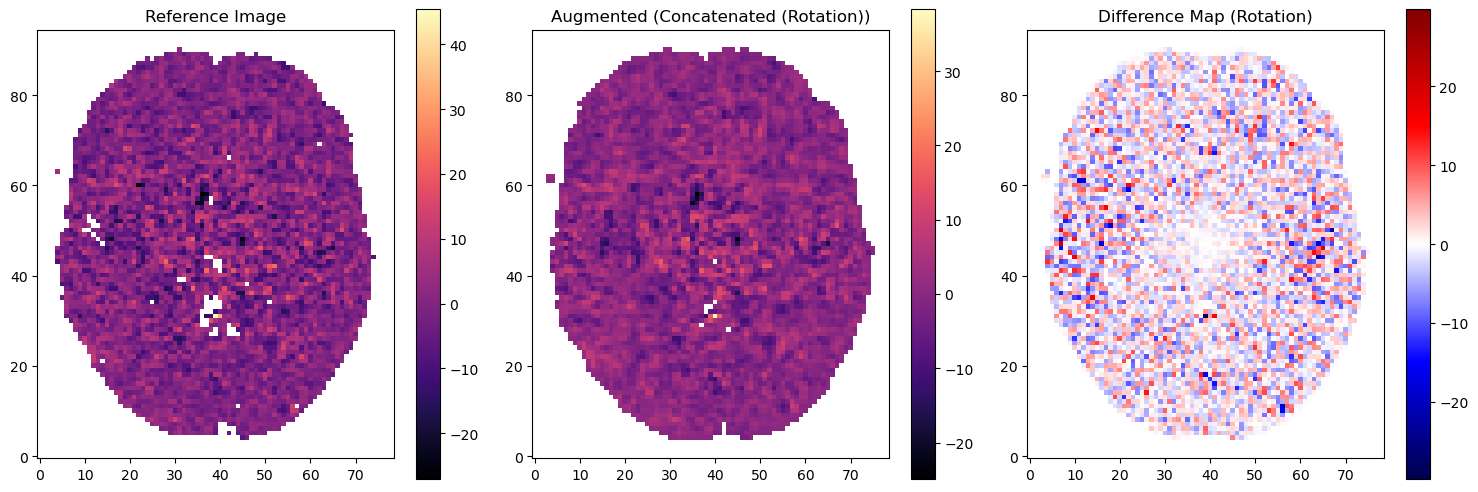


--- Plotting fMRI Intensity Noise ---


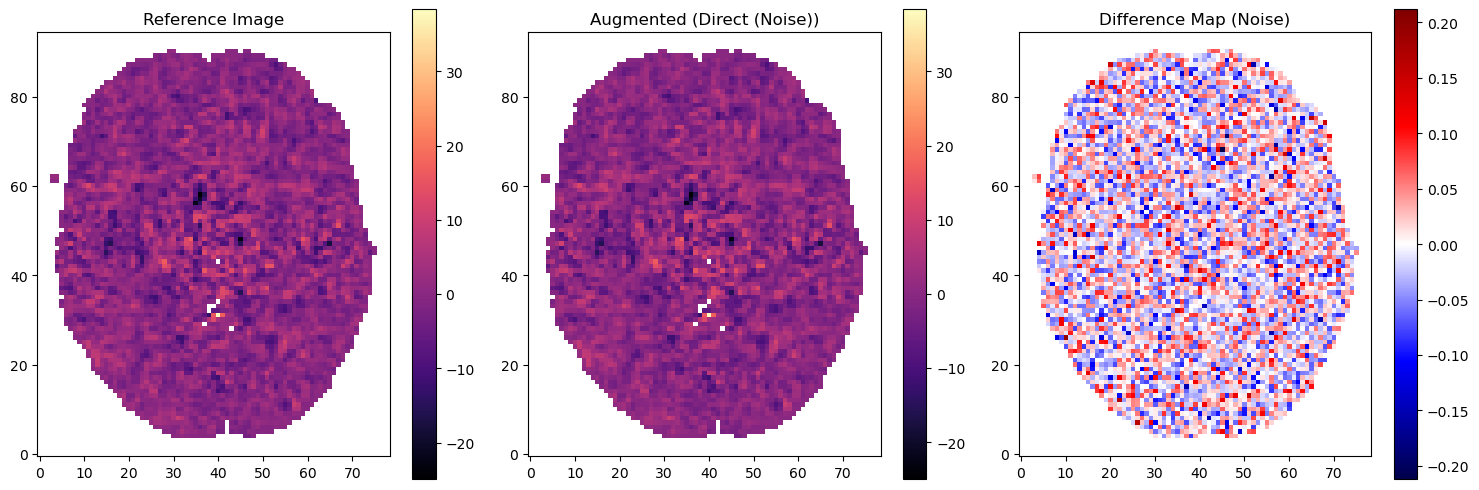

In [8]:
# --- 1. EEG PLOTTING ---
if 'eeg_data' in locals() and 'X_eeg_aug' in locals():
    print("\n--- Plotting EEG Augmentation ---")
    plot_eeg_augmentation(eeg_data, X_eeg_aug, orig_idx=0, channel_idx=5)

# --- 2. fMRI PLOTTING ---
if 'fmri_data' in locals():
    print("\n--- Plotting fMRI Rotation ---")
    # Compare Clean Original vs. Rotated Version
    # plot_fmri_augmentation detects length mismatch and picks the 2nd half
    plot_fmri_augmentation(fmri_clean, X_fmri_geo, trial_idx=0, title_suffix="(Rotation)")
    
    print("\n--- Plotting fMRI Intensity Noise ---")
    # Compare Rotated vs. Rotated+Noise
    # plot_fmri_augmentation detects same length and compares 1-to-1
    plot_fmri_augmentation(X_fmri_geo, X_fmri_aug, trial_idx=len(fmri_clean), title_suffix="(Noise)")

In [9]:
X_eeg, y_eeg = X_eeg_aug, y_eeg_aug

# Intensity second (Adds noise to everything)
X_fmri = X_fmri_aug
# Note: augment_fmri_intensity returns X + noise, so we just use that result
y_fmri = y_fmri_geo

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
print(f"EEG Shape: {X_eeg.shape}")   # (N_samples, Channels, Time)
print(f"fMRI Shape: {X_fmri.shape}") # (N_samples, X, Y, Z)

# --- 2. PREPARE FOR ML (FLATTENING) ---
# Standard ML models (SVM/RF) expect 2D data: (Samples, Features)
# We must flatten the time/spatial dimensions into one long feature vector.

# Flatten EEG: (N, Ch, Time) -> (N, Ch * Time)
n_samples_eeg = X_eeg.shape[0]
X_eeg_flat = X_eeg.reshape(n_samples_eeg, -1)

# Flatten fMRI: (N, X, Y, Z) -> (N, X*Y*Z)
n_samples_fmri = X_fmri.shape[0]
X_fmri_flat = X_fmri.reshape(n_samples_fmri, -1)

print(f"EEG Flattened: {X_eeg_flat.shape}")
print(f"fMRI Flattened: {X_fmri_flat.shape}")

# --- 3. DEFINE BASELINES ---
# We use a Pipeline to scale the data first (critical for SVM)
svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0))
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Define Validation Strategy (5-Fold Cross-Validation)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def run_baseline(name, X, y, model):
    print(f"\n--- Running {name} ---")
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"Accuracy per fold: {scores}")
    print(f"Mean Accuracy: {scores.mean():.2%} (+/- {scores.std():.2%})")
    return scores.mean()

# --- 4. EXECUTE ---
print("\n==========================")
print("   BASELINE RESULTS       ")
print("==========================")

# EEG Baselines
#acc_svm_eeg = run_baseline("EEG (SVM)", X_eeg_flat, y_eeg, svm_pipeline)
acc_rf_eeg  = run_baseline("EEG (Random Forest)", X_eeg_flat, y_eeg, rf_model)

# fMRI Baselines
#acc_svm_fmri = run_baseline("fMRI (SVM)", X_fmri_flat, y_fmri, svm_pipeline)
acc_rf_fmri  = run_baseline("fMRI (Random Forest)", X_fmri_flat, y_fmri, rf_model)

print("\nSummary:")
print(f"Best EEG Model: {acc_rf_eeg:.2%}")
print(f"Best fMRI Model: {acc_rf_fmri:.2%}")

EEG Shape: (640, 64, 1280)
fMRI Shape: (640, 79, 95, 79)
EEG Flattened: (640, 81920)
fMRI Flattened: (640, 592895)

   BASELINE RESULTS       

--- Running EEG (SVM) ---
